<a href="https://colab.research.google.com/github/siddharth-sudhakar/Deep_Dream/blob/main/DeepDream.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Load all libraries
import tensorflow as tf
import numpy as np
import matplotlib as mpl
import IPython.display as display
import PIL.Image
from matplotlib import pyplot as plt
from tensorflow.keras.preprocessing import image

In [2]:
#Downloading an image from an URL
url = 'https://variety.com/wp-content/uploads/2020/07/ryan-reynolds.jpg' #URL of the image
def get_image(url, max_dim=None): #Function to get image
  name = url.split('/')[-1]                              #Loads the file name from the image, in this case: ryan-reynolds.jpg
  image_path = tf.keras.utils.get_file(name, origin=url) #Downloads the file from the URL
  img = PIL.Image.open(image_path)                       #Opens file using Python Imaging Library
  if max_dim:
    img.thumbnail((max_dim, max_dim))                    #Resizes the image, using thumbnail instead of resize to preserve aspect ratio
  return np.array(img)

In [3]:
#normalizes the intensity values
def deprocess(img):
  img = 255*(img + 1.0)/2.0
  return tf.cast(img, tf.uint8)

In [4]:
#Function to show an image
def show_img(img):
  display.display(PIL.Image.fromarray(np.array(img)))

400667/400667 [==============================] - 0s 0us/step


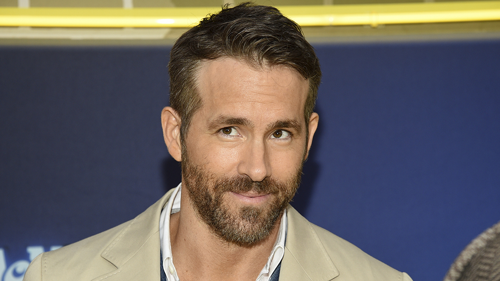

In [5]:
#Testing whether the said image works
original_img = get_image(url, max_dim=500)
show_img(original_img)

In [6]:
original_img.shape #So that's a 281 x 500 image, the 3 represents the colors

(281, 500, 3)

In [7]:
base_model = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet') #Imports the InceptionV3 model, exculding the dense layers, using ImageNet weights.
base_model.summary()

87910968/87910968 [==============================] - 3s 0us/step
Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv2d (Conv2D)                (None, None, None,   864         ['input_1[0][0]']                
                                32)                                                               
                                                                                                  
 batch_normalization (BatchNorm  (None, None, None,   96         ['conv2d[0][0]']                 
 alization)           

In [8]:
names = ['mixed2', 'mixed5'] #Layers chosen for Deepdream

In [9]:
layers = [base_model.get_layer(name).output for name in names]

In [10]:
dream_model = tf.keras.Model(inputs=base_model.input, outputs=layers) #Transferring the InceptionV3 to the DeepDream model

In [11]:
def get_loss(img, model):
  # Pass forward the image through the model to retrieve the activations.
  # Converts the image into a batch of size 1.
  img_batch = tf.expand_dims(img, axis=0) #Batch size is set as 1
  layer_activations = model(img_batch)
  if len(layer_activations) == 1:
    layer_activations = [layer_activations]

  losses = []
  for act in layer_activations:
    loss = tf.math.reduce_mean(act)
    losses.append(loss)

  return  tf.reduce_sum(losses)

In [12]:
class DeepDream(tf.Module):
  def __init__(self, model):
    self.model = model

  @tf.function(
      input_signature=(
        tf.TensorSpec(shape=[None,None,3], dtype=tf.float32),
        tf.TensorSpec(shape=[], dtype=tf.int32),
        tf.TensorSpec(shape=[], dtype=tf.float32),)
  )
  def __call__(self, img, steps, step_size):
      print("Tracing")
      loss = tf.constant(0.0)
      for n in tf.range(steps):
        with tf.GradientTape() as tape:
          # This needs gradients relative to `img`
          # `GradientTape` only watches `tf.Variable`s by default
          tape.watch(img)
          loss = get_loss(img, self.model)

        # Calculate the gradient of the loss with respect to the pixels of the input image.
        gradients = tape.gradient(loss, img)

        # Normalize the gradients.
        gradients /= tf.math.reduce_std(gradients) + 1e-8 
        img = img + gradients*step_size
        img = tf.clip_by_value(img, -1, 1)

      return loss, img

In [13]:
deepdream = DeepDream(dream_model)

In [14]:
def run_deep_dream(img, steps=100, step_size=0.01):
  # Convert from uint8 to the range expected by the model.
  img = tf.keras.applications.inception_v3.preprocess_input(img)
  img = tf.convert_to_tensor(img)
  step_size = tf.convert_to_tensor(step_size)
  steps_remaining = steps
  step = 0
  while steps_remaining:
    if steps_remaining>100:
      run_steps = tf.constant(100)
    else:
      run_steps = tf.constant(steps_remaining)
    steps_remaining -= run_steps
    step += run_steps

    loss, img = deepdream(img, run_steps, tf.constant(step_size))

    display.clear_output(wait=True)
    show_img(deprocess(img))
    print ("Step {}, loss {}".format(step, loss))

  result = deprocess(img)
  display.clear_output(wait=True)
  show_img(result)

  return result

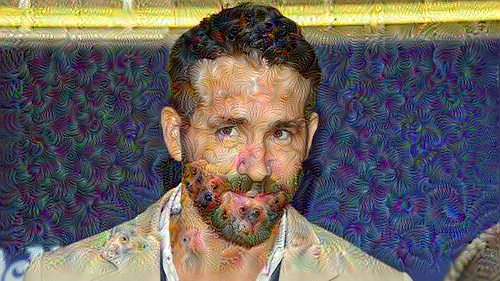

In [15]:
dream_img = run_deep_dream(img=original_img, steps=100, step_size=0.01)

In [16]:
OCTAVE_SCALE = 1.30

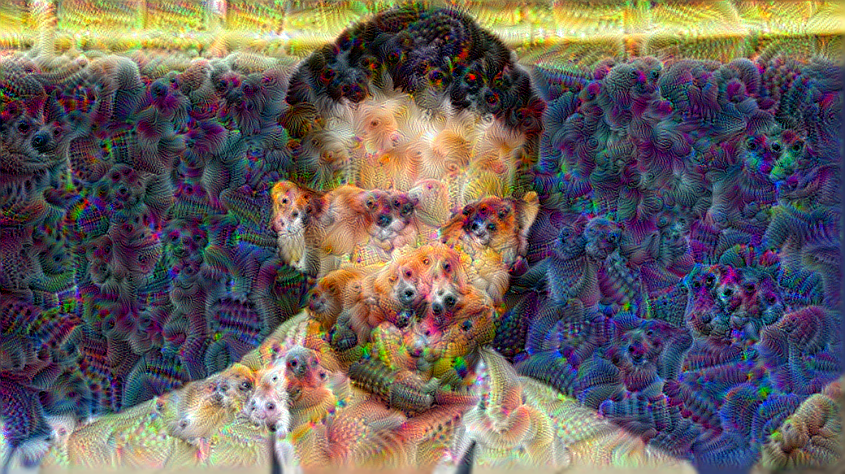

In [17]:
img = tf.constant(np.array(original_img))
base_shape = tf.shape(img)[:-1]
float_base_shape = tf.cast(base_shape, tf.float32)

for n in range(-2, 3):
  new_shape = tf.cast(float_base_shape*(OCTAVE_SCALE**n), tf.int32)
  img = tf.image.resize(img, new_shape).numpy()
  img = run_deep_dream(img=img, steps=50, step_size=0.01)

display.clear_output(wait=True)
img = tf.image.resize(img, new_shape)
img = tf.image.convert_image_dtype(img/255.0, dtype=tf.uint8)
show_img(img)